## Reproduction of the UniformatBridge model implementation

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

**Table of contents**    
- Reproduction of the UniformatBridge model implementation    
    - Data    
      - BIM and ASTM Uniformat categories    
      - ★ Additional Experiment: What if we simply duplicate scarce data for data balancing?    
      - Label Encoding    
      - Text Encoding    
      - Make DataLoader    
      - ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description    
      - ★ Additional Datasets: Data Augmentation with GPT-2    
      - ★ Additional Datasets: Data Augmentation with GPT-4    
    - Fine-tuning (Train & Validation)    
    - Test    
    - Experimental Results    
      - Overall Results    
      - Class-wise Results    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import time; start_time = time.time()

In [2]:
!python -V

Python 3.11.6


In [3]:
# Experimental Settings from Jung et al. (2024)
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 20 #5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

# 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
rseed = 42

In [4]:
experiment_name = 'gpt4_balancing'  # for writing output file names.
experiment_setting = {
    'rseed': rseed, 
    'simple_balancing': False, # 'True' takes long time to train
    'gpt2_balancing': False,
    'gpt4_balancing': True,
}

import json
with open(f'experimental_results/{experiment_name}_experiment_setting.json', 'w') as json_file:
    json.dump(experiment_setting, json_file, indent=4, sort_keys=True)

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [6]:
import pandas as pd
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [7]:
new_tokens = ['[pred]', '[succ]']

df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)
df['label'] = df[cls]
label_cnt = df['label'].value_counts()

print_idx = 6538  # D2040: 'Rain Water Drainage' case in Table 4
print('text: ', df['text'][print_idx])
print('label: ', df['label'][print_idx])

text:  CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP
label:  D2040


In [8]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### ★ Additional Experiment: What if we simply duplicate scarce data for data balancing?

In [9]:
if experiment_setting['simple_balancing']:
    label_counts = train_labels.value_counts()

    # Set the frequency of the most frequent label as the target for all labels
    max_count = label_counts.max()

    train_texts_balanced = []
    train_labels_balanced = []
    for label, count in label_counts.items():
        # Calculate how many times to duplicate based on the target frequency
        factor = max_count // count
        remainder = max_count % count
        
        # Select texts corresponding to the current label
        texts_of_label = train_texts[train_labels == label]
        
        # Duplicate texts to match the target frequency
        for _ in range(factor):
            train_texts_balanced.extend(texts_of_label)
            train_labels_balanced.extend([label] * len(texts_of_label))
        
        if remainder > 0:
            train_texts_balanced.extend(texts_of_label[:remainder])
            train_labels_balanced.extend([label] * remainder)

    train_texts = pd.Series(train_texts_balanced)
    train_labels = pd.Series(train_labels_balanced)

    # Data should not be shared publicly.
    pd.DataFrame({'text': train_texts, 'label': train_labels}).to_csv(dataset_path+f"/train_data_balanced_{experiment_name}.csv", index=False)
    print(train_labels.value_counts().head())

#### Label Encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(labels)

train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

#### Text Encoding

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

tokenizer, model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	30522: AddedToken("[pred]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
 	30523: AddedTo

#### Make DataLoader

In [12]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloader(plain_texts, encoded_labels, batch_size=32):
    '''
    plain_texts: list of strings (should be encoded when making dataloader due to tokenizer padding/truncation)
    encoded_labels: list of class indices (should be encoded beforehand using LabelEncoder with the entire dataset)
    '''
    texts = tokenizer(plain_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
    dataset = TensorDataset(
        texts['input_ids'], 
        texts['attention_mask'], 
        labels,
    )
    return DataLoader(dataset, batch_size=batch_size)

train_loader = make_dataloader(train_texts.tolist(), train_labels_encoded, batch_size)
validation_loader = make_dataloader(validation_texts.tolist(), validation_labels_encoded, batch_size)
test_loader = make_dataloader(test_texts.tolist(), test_labels_encoded, batch_size)

len(train_loader), len(validation_loader), len(test_loader)

(640, 214, 214)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description

In [13]:
import pandas as pd

# Publicly available definition of ASTM Uniformat II
# https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf
df_astm = pd.read_csv("public_astm_uniformat_ii_classification.csv", header=0)

df_astm = df_astm[df_astm['Class'].isin(label_encoder.classes_)] # Use only the classes that are in the dataset
df_astm

,Level1,Level2,Level3,Class
0,SUBSTRUCTURE,Foundations,Standard Foundations,A1010
1,SUBSTRUCTURE,Foundations,Special Foundations,A1020
2,SUBSTRUCTURE,Foundations,Slab on Grade,A1030
3,SHELL,Superstructure,Floor Construction,B1010
4,SHELL,Superstructure,Roof Construction,B1020
5,SHELL,Exterior Enclosure,Exterior Walls,B2010
6,SHELL,Exterior Enclosure,Exterior Windows,B2020
7,SHELL,Exterior Enclosure,Exterior Doors,B2030
8,SHELL,Roofing,Roof Coverings,B3010
9,SHELL,Roofing,Roof Openings,B3020


#### ★ Additional Datasets: Data Augmentation with GPT-2

In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

set_seed(42)

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

def generate_sentences_with_gpt2(prompt_text, max_len=100, num_sentences=20):
    inputs = gpt2_tokenizer.encode(prompt_text, return_tensors='pt')
    outputs = gpt2_model.generate(
        inputs, 
        pad_token_id=gpt2_tokenizer.eos_token_id, 
        max_length=max_len, 
        do_sample=True, temperature=0.7, num_return_sequences=num_sentences,
        # repetition_penalty=1.2,
    )
    if len(outputs) == 1: # Deterministic setting
        generated_text = [gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)] * num_sentences
    else:
        generated_text = [gpt2_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return generated_text

generate_sentences_with_gpt2("Once upon a time,", num_sentences=1)

["Once upon a time, the United States was already a strong contender to compete in World Baseball Classic qualifying, and the team was expected to be the World Baseball Classic's best player for the next few years. However, the team's lack of experience could put it in a precarious position.\n\nIn fact, the team's decision to change its name to K-Mart in order to avoid confusion with the name of the new stadium was also a mistake made. The K-Mart name was used only"]

In [15]:
def generate_with_gpt2_for_astm(level1, level2, level3):

    prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
    
    sentences = []
    for sentence in generate_sentences_with_gpt2(prompt):
        sentence = sentence[len(prompt):]
        for remove_char in ['\n']: #, '.', '•', '·']:
            sentence = sentence.replace(remove_char, ' ')
        sentence = level1 + " " + level2 + " " + level3 + sentence
        sentences.append(sentence)
    return sentences

generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

['SERVICES Plumbing Rain Water Drainage:  1. Water pumps  1.1.1.1.1.1.2. Water pumps are a combination of pumps and pipes which are installed by one entity in a building. The building must use water as a primary source of power, which carries the risk of flooding.  1.1.1.1.2.1.1.1.1.2.1.3',
 'SERVICES Plumbing Rain Water Drainage shown in Figures 1-5. Figure 1. Building structure components for services of water and sewer systems. (a) A concrete structure is shown in Figures 1-3 and Figure 1-4. It is in the form of a concrete structure with a central block with a single, central, and horizontal section. (b) A concrete structure is shown in Figures 1-2 and Figure 1-3. It is in the',
 'SERVICES Plumbing Rain Water Drainage:  The structure will have a wide gap between the two walls, and the roof will be curved up to make it easier to cut through the gaps.  The interior will be made of polyethylene, and the inside will be made of polypropylene.  The roof will be made of a polyethylene mate

In [16]:
if experiment_setting['gpt2_balancing']:

    from tqdm import tqdm
    gpt2_texts = []
    gpt2_labels = []
    for _, row in tqdm(df_astm.iterrows(), total=df_astm.shape[0]):
        sentences = generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])
        for sentence in sentences:
            gpt2_texts.append(sentence)
            gpt2_labels.append(row['Class'])
    generated_df = pd.DataFrame({'text': gpt2_texts, 'label': gpt2_labels})
    generated_df.to_csv(dataset_path+f"/gpt2_data_{experiment_name}.csv", index=False)

    import itertools
    train_loader = make_dataloader(
        list(itertools.chain(
            train_texts,
            gpt2_texts,
        )),
        list(itertools.chain(
            train_labels_encoded,
            label_encoder.transform(gpt2_labels),
        )),
        batch_size
    )

len(train_loader)

640

#### ★ Additional Datasets: Data Augmentation with GPT-4

In [17]:
gpt4_texts = [
    # Real data
    # 'CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP',
    # 'Garage Garage Structure | MEP FP | Finishes > LL1 > OH Sprinkler Piping Rough In LL1 [pred] Garage Garage Structure | MEP FP | Finishes > LL1 > OH Storm Drainage Piping Rough In LL1 [succ] Garage Garage Structure | MEP FP | Finishes > LL1 > Install Pipe Guards | Bollards LL1',

    # Generated with prompt: sample 20 tasks of ASTM Uniformat D2040 'SERVICES Plumbing Rain Water Drainage' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask'
    'Initiation > Planning > Review Project Scope [pred] SERVICES > Plumbing Rain Water Drainage > Develop Rainwater Drainage Design [succ] > SERVICES > Plumbing Rain Water Drainage > Select Drainage Materials',
    'SERVICES > Plumbing Rain Water Drainage > Develop Rainwater Drainage Design [pred] SERVICES > Plumbing Rain Water Drainage > Select Drainage Materials [succ] > SERVICES > Plumbing Rain Water Drainage > Finalize Drainage Design',
    'SERVICES > Plumbing Rain Water Drainage > Select Drainage Materials [pred] SERVICES > Plumbing Rain Water Drainage > Finalize Drainage Design [succ] > SERVICES > Plumbing Rain Water Drainage > Obtain Permits',
    'SERVICES > Plumbing Rain Water Drainage > Finalize Drainage Design [pred] SERVICES > Plumbing Rain Water Drainage > Obtain Permits [succ] > SERVICES > Plumbing Rain Water Drainage > Prepare Site for Drainage Work',
    'SERVICES > Plumbing Rain Water Drainage > Obtain Permits [pred] SERVICES > Plumbing Rain Water Drainage > Prepare Site for Drainage Work [succ] > SERVICES > Plumbing Rain Water Drainage > Install Underground Drainage Piping',
    'SERVICES > Plumbing Rain Water Drainage > Prepare Site for Drainage Work [pred] SERVICES > Plumbing Rain Water Drainage > Install Underground Drainage Piping [succ] > SERVICES > Plumbing Rain Water Drainage > Install Drainage Catch Basins',
    'SERVICES > Plumbing Rain Water Drainage > Install Underground Drainage Piping [pred] SERVICES > Plumbing Rain Water Drainage > Install Drainage Catch Basins [succ] > SERVICES > Plumbing Rain Water Drainage > Install Roof Gutters and Downspouts',
    'SERVICES > Plumbing Rain Water Drainage > Install Drainage Catch Basins [pred] SERVICES > Plumbing Rain Water Drainage > Install Roof Gutters and Downspouts [succ] > SERVICES > Plumbing Rain Water Drainage > Connect to Stormwater System',
    'SERVICES > Plumbing Rain Water Drainage > Install Roof Gutters and Downspouts [pred] SERVICES > Plumbing Rain Water Drainage > Connect to Stormwater System [succ] > SERVICES > Plumbing Rain Water Drainage > Backfill and Compact Around Piping',
    'SERVICES > Plumbing Rain Water Drainage > Connect to Stormwater System [pred] SERVICES > Plumbing Rain Water Drainage > Backfill and Compact Around Piping [succ] > SERVICES > Plumbing Rain Water Drainage > Waterproofing and Insulation of Piping',
    'SERVICES > Plumbing Rain Water Drainage > Backfill and Compact Around Piping [pred] SERVICES > Plumbing Rain Water Drainage > Waterproofing and Insulation of Piping [succ] > SERVICES > Plumbing Rain Water Drainage > Pressure Test Drainage System',
    'SERVICES > Plumbing Rain Water Drainage > Waterproofing and Insulation of Piping [pred] SERVICES > Plumbing Rain Water Drainage > Pressure Test Drainage System [succ] > SERVICES > Plumbing Rain Water Drainage > Adjustments and Repairs',
    'SERVICES > Plumbing Rain Water Drainage > Pressure Test Drainage System [pred] SERVICES > Plumbing Rain Water Drainage > Adjustments and Repairs [succ] > SERVICES > Plumbing Rain Water Drainage > Landscape Restoration',
    'SERVICES > Plumbing Rain Water Drainage > Adjustments and Repairs [pred] SERVICES > Plumbing Rain Water Drainage > Landscape Restoration [succ] > SERVICES > Plumbing Rain Water Drainage > Final Inspection and Approval',
    'SERVICES > Plumbing Rain Water Drainage > Landscape Restoration [pred] SERVICES > Plumbing Rain Water Drainage > Final Inspection and Approval [succ] > Project Closeout > Documentation > Compile Project Documentation',
    'SERVICES > Plumbing Rain Water Drainage > Final Inspection and Approval [pred] Project Closeout > Documentation > Compile Project Documentation [succ] > Project Closeout > Client Training > Provide Maintenance and Operation Training',
    'Project Closeout > Documentation > Compile Project Documentation [pred] Project Closeout > Client Training > Provide Maintenance and Operation Training [succ] > Project Closeout > Warranty > Establish Warranty Period',
    'Project Closeout > Client Training > Provide Maintenance and Operation Training [pred] Project Closeout > Warranty > Establish Warranty Period [succ] > Project Closeout > Feedback > Conduct Post-Project Review',
    'Project Closeout > Warranty > Establish Warranty Period [pred] Project Closeout > Feedback > Conduct Post-Project Review [succ] > Project Closeout > Feedback > Implement Lessons Learned',
    'Project Closeout > Feedback > Conduct Post-Project Review [pred] Project Closeout > Feedback > Implement Lessons Learned [succ] > Project Closeout > Finalization > Release Project Team and Resources',

    # sample 20 tasks of ASTM Uniformat D2040 'SERVICES Plumbing Rain Water Drainage' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask' including various building construction components.
    'Site Preparation > Excavation > Site Clearing [pred] SERVICES > Plumbing Rain Water Drainage > Install Underground Drainage Pipes [succ] > Foundation > Basement Construction > Waterproofing',
    'Architectural > Roofing > Install Roof Underlayment [pred] SERVICES > Plumbing Rain Water Drainage > Install Roof Drainage Systems [succ] > Exterior Enclosures > Roof Finishes > Install Gutters and Downspouts',
    'Mechanical > HVAC Systems > Ductwork Installation [pred] SERVICES > Plumbing Rain Water Drainage > Connection to HVAC Condensate Drain Lines [succ] > Plumbing > Sanitary Systems > Connect to Sanitary Drainage System',
    'Civil > Site Services > Stormwater Management Planning [pred] SERVICES > Plumbing Rain Water Drainage > Design of Rainwater Harvesting System [succ] > Landscaping > Irrigation Systems > Implement Rainwater Harvesting for Irrigation',
    'Architectural > External Walls > Install External Cladding [pred] SERVICES > Plumbing Rain Water Drainage > Ensure Proper Wall Flashing for Water Drainage [succ] > Architectural > Paints and Coatings > Apply Exterior Waterproof Coatings',
    'Civil > Landscaping > Site Grading for Drainage [pred] SERVICES > Plumbing Rain Water Drainage > Install French Drains [succ] > Landscaping > Hardscaping > Install Drainage Grates in Pavements',
    'Utilities > Water Supply Systems > Install Water Mains [pred] SERVICES > Plumbing Rain Water Drainage > Connection to Municipal Storm Sewers [succ] > Utilities > Sewer Systems > Connect to Public Sewer System',
    'Architectural > Windows and Doors > Install Windows [pred] SERVICES > Plumbing Rain Water Drainage > Install Window Well Drains [succ] > Architectural > Basement > Waterproof Basement Windows',
    'Mechanical > Fire Protection > Sprinkler System Installation [pred] SERVICES > Plumbing Rain Water Drainage > Integrate Sprinkler Drainage [succ] > Plumbing > Drainage Systems > Connect Sprinkler Drainage to Main Drain',
    'Structural > Foundations > Pour Concrete Foundations [pred] SERVICES > Plumbing Rain Water Drainage > Install Drainage Mat for Foundation Walls [succ] > Structural > Foundation Finishes > Apply Dampproofing',
    'Landscaping > Outdoor Lighting > Install Pathway Lights [pred] SERVICES > Plumbing Rain Water Drainage > Incorporate Drainage in Outdoor Lighting Plan [succ] > Electrical > Exterior Electrical > Provide Drainage for Outdoor Electrical Systems',
    'Structural > Columns and Beams > Steel Erection [pred] SERVICES > Plumbing Rain Water Drainage > Ensure Column Bases Drain Properly [succ] > Architectural > Metalwork > Install Metal Flashing at Base of Columns',
    'Utilities > Electrical Service > Install Electrical Conduits [pred] SERVICES > Plumbing Rain Water Drainage > Seal Conduits Against Water Entry [succ] > Electrical > Electrical Protection > Install Waterproof Conduit Seals',
    'Architectural > Interior Partitions > Erect Partition Walls [pred] SERVICES > Plumbing Rain Water Drainage > Install Internal Drainage Within Partitions [succ] > Interior Finishes > Interior Painting > Paint After Drainage Installation',
    'Civil > Parking > Construct Parking Lots [pred] SERVICES > Plumbing Rain Water Drainage > Design Drainage for Parking Areas [succ] > Civil > Pavements > Install Permeable Pavements for Improved Drainage',
    'Mechanical > Elevators > Elevator Shaft Construction [pred] SERVICES > Plumbing Rain Water Drainage > Install Drainage in Elevator Pits [succ] > Electrical > Elevator Controls > Waterproof Elevator Control Rooms',
    'Utilities > Gas Systems > Gas Line Installation [pred] SERVICES > Plumbing Rain Water Drainage > Integrate Drainage Around Gas Meters [succ] > Utilities > Metering > Waterproof Meter Enclosures',
    'Architectural > Insulation > Install Thermal Insulation [pred] SERVICES > Plumbing Rain Water Drainage > Manage Condensation Drainage [succ] > Mechanical > HVAC Systems > Connect Condensation Drains to HVAC',
    'Electrical > Lighting > Install Interior Lighting [pred] SERVICES > Plumbing Rain Water Drainage > Plan Drainage for Emergency Exit Lights [succ] > Safety and Security > Emergency Systems > Ensure Water Does Not Obstruct Emergency Exits',
    'Landscaping > Planting > Plant Trees and Shrubs [pred] SERVICES > Plumbing Rain Water Drainage > Implement Root Zone Drainage Solutions [succ] > Landscaping > Soil and Vegetation > Apply Soil Amendments for Improved Drainage',

    # Prompt: Sample 20 tasks of ASTM Uniformat D2040 'SERVICES Plumbing Rain Water Drainage' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask' including various building construction components.
    'SITEWORK > Exterior Utilities > Install Underground Drainage Piping [pred] SITEWORK > Exterior Utilities > Backfill & Compact Around Underground Drainage [succ] SERVICES > Plumbing Rain Water Drainage > Test & Inspect Underground Drainage',
    'SERVICES > Plumbing Rain Water Drainage > Install Roof Drainage Outlets [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Connect Roof Drains to Downspouts [succ] SERVICES > Plumbing Rain Water Drainage > Install Downspout Cleanouts',
    'CONSTRUCTION SUPERSTRUCTURE > Roof > Install Rainwater Harvesting System [pred] SERVICES > Plumbing Rain Water Drainage > Connect Harvesting System to Storage Tanks [succ] SERVICES > Plumbing Rain Water Drainage > Integrate Rainwater System with Irrigation',
    'SERVICES > Plumbing Rain Water Drainage > Layout Underground Storm Drainage Pipes [pred] SITEWORK > Landscaping > Avoid Trees and Roots in Drainage Path [succ] SERVICES > Plumbing Rain Water Drainage > Install Catch Basins and Manholes',
    'FOUNDATION > Foundation Drainage > Install Perimeter Drainage System [pred] SERVICES > Plumbing Rain Water Drainage > Connect Downspouts to Perimeter Drainage [succ] SITEWORK > Grading > Ensure Proper Slope for Drainage Away from Foundation',
    'SERVICES > Plumbing Rain Water Drainage > Install Sump Pumps in Basements [pred] SERVICES > Plumbing Rain Water Drainage > Connect Sump Pump Discharge to Storm Drain [succ] ELECTRICAL > Power Generation > Provide Backup Power for Sump Pumps',
    'CONSTRUCTION SUPERSTRUCTURE > Facades > Install Flashing and Waterproofing [pred] SERVICES > Plumbing Rain Water Drainage > Seal Around Drainage Entry Points [succ] CONSTRUCTION SUPERSTRUCTURE > Exterior Walls > Ensure Water-Tightness of Exterior Joints',
    'SERVICES > Plumbing Rain Water Drainage > Design Rainwater Recycling System [pred] MECHANICAL > HVAC > Integrate Rainwater Use for Cooling Towers [succ] SERVICES > Plumbing Rain Water Drainage > Monitor and Control Water Quality for Recycling',
    'SERVICES > Plumbing Rain Water Drainage > Install Gutter Guards and Screens [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Clean and Maintain Roof Drainage Pathways [succ] SERVICES > Plumbing Rain Water Drainage > Schedule Regular Drainage System Inspections',
    'SERVICES > Plumbing Rain Water Drainage > Install Overflow Scuppers on Flat Roofs [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Waterproof Around Scuppers [succ] SERVICES > Plumbing Rain Water Drainage > Test Scupper Performance during Rain',
    'INTERIORS > Ceilings > Install Access Panels for Drainage System Maintenance [pred] SERVICES > Plumbing Rain Water Drainage > Route Drainage Pipes Above Ceilings [succ] INTERIORS > Ceilings > Restore Ceiling Finish After Pipe Installation',
    'SERVICES > Plumbing Rain Water Drainage > Design Grated Trench Drains for Patios [pred] SITEWORK > Exterior Hardscaping > Install Trench Drains in Concrete [succ] SERVICES > Plumbing Rain Water Drainage > Connect Trench Drains to Stormwater System',
    'SERVICES > Plumbing Rain Water Drainage > Implement Green Roof Drainage Layer [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Plant Vegetation on Green Roof [succ] SERVICES > Plumbing Rain Water Drainage > Ensure Adequate Drainage for Roof Garden',
    'SERVICES > Plumbing Rain Water Drainage > Install French Drains Around Walkways [pred] SITEWORK > Landscaping > Grade Land to Direct Water to French Drains [succ] SERVICES > Plumbing Rain Water Drainage > Cover French Drains with Gravel and Landscaping',
    'SERVICES > Plumbing Rain Water Drainage > Design Stormwater Detention System [pred] SITEWORK > Site Improvements > Construct Detention Pond [succ] SERVICES > Plumbing Rain Water Drainage > Integrate Detention System with Local Stormwater Infrastructure',
    'SERVICES > Plumbing Rain Water Drainage > Specify Water-Resistant Materials for Drainage Channels [pred] PROCUREMENT & CONTRACTING > Material Ordering > Order Drainage Channel Materials [succ] CONSTRUCTION > Exterior Finishes > Install Drainage Channels with Specified Materials',
    'SERVICES > Plumbing Rain Water Drainage > Develop Stormwater Pollution Prevention Plan [pred] SITEWORK > Environmental Controls > Implement Erosion and Sediment Controls [succ] SERVICES > Plumbing Rain Water Drainage > Monitor Site for Compliance with Stormwater Regulations',
    'SERVICES > Plumbing Rain Water Drainage > Install Backflow Preventers for Drainage Systems [pred] PLUMBING > Water Supply Systems > Protect Potable Water from Contamination [succ] SERVICES > Plumbing Rain Water Drainage > Test Backflow Preventers Annually',
    'SERVICES > Plumbing Rain Water Drainage > Design Subsurface Drainage for Athletic Fields [pred] SITEWORK > Recreational Areas > Construct Underdrain System for Fields [succ] SERVICES > Plumbing Rain Water Drainage > Connect Field Drainage to Main Storm Drain',
    'SERVICES > Plumbing Rain Water Drainage > Install Downspout Disconnection Devices [pred] ENVIRONMENTAL SYSTEMS > Sustainable Systems > Promote Rainwater Infiltration in Landscaped Areas [succ] SERVICES > Plumbing Rain Water Drainage > Monitor Effectiveness of Disconnection Devices',

    'SITE CONSTRUCTION > Site Services > Install Underground Storm Drainage Piping [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Catch Basins [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Backfill and Compact Around Drainage',
    'FOUNDATION > Basement Construction > Waterproofing [pred] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Install Sump Pumps [succ] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Connect Sump Pump to Exterior Drainage',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Gutter Systems on Roof [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Gutters to Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Underground Drainage From Downspouts',
    'CONSTRUCTION SUPERSTRUCTURE > Roof > Install Roof Drains [pred] SERVICES Plumbing Rain Water Drainage > Roof Systems > Connect Roof Drains to Internal Drainage System [succ] SERVICES Plumbing Rain Water Drainage > Interior Systems > Install Internal Drainage Pipes Within Walls',
    'SERVICES Plumbing Rain Water Drainage > Roof Systems > Install Green Roof Drainage Layer [pred] SERVICES Plumbing Rain Water Drainage > Roof Systems > Install Green Roof Vegetation [succ] SERVICES Plumbing Rain Water Drainage > Roof Systems > Maintenance Access for Green Roof Drainage',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Layout Exterior French Drains [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Perforated Pipe for French Drains [succ] LANDSCAPING > Exterior > Backfill and Landscape Over French Drains',
    'CONSTRUCTION SUPERSTRUCTURE > Facade > Install Downspout Brackets on Exterior Wall [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Downspouts to Stormwater Management System',
    'SERVICES Plumbing Rain Water Drainage > Roof Systems > Install Scuppers for Flat Roof [pred] SERVICES Plumbing Rain Water Drainage > Roof Systems > Connect Scuppers to Leader Pipes [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Direct Leader Pipes to Discharge Points',
    'FOUNDATION > Basement Construction > Install Basement Drainage Channels [pred] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Connect Basement Drainage to Sump Pit [succ] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Test Basement Drainage System',
    'SERVICES Plumbing Rain Water Drainage > Interior Systems > Rough-in for Internal Stormwater Pipes [pred] SERVICES Plumbing Rain Water Drainage > Interior Systems > Install Water Traps for Floor Drains [succ] FINISHES > Interior > Install Final Flooring Over Drainage Access Points',
    'SERVICES Plumbing Rain Water Drainage > Roof Systems > Layout Roof Drainage Piping [pred] SERVICES Plumbing Rain Water Drainage > Roof Systems > Insulate Roof Drainage Piping [succ] CONSTRUCTION SUPERSTRUCTURE > Roof > Complete Roof Membrane Installation Around Drainage',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Stormwater Infiltration System [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Infiltration System to Site Drainage [succ] SITE CONSTRUCTION > Landscaping > Restore Landscape After Infiltration System Installation',
    'CONSTRUCTION SUPERSTRUCTURE > Roof > Designate Areas for Rainwater Harvesting Equipment [pred] SERVICES Plumbing Rain Water Drainage > Roof Systems > Install Rainwater Harvesting Filters [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Harvesting System to Storage Tanks',
    'SERVICES Plumbing Rain Water Drainage > Substructure Systems > Excavate for Underground Drainage [pred] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Lay Gravel Base for Drainage Pipes [succ] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Install and Cover Underground Drainage Pipes',
    'SITE CONSTRUCTION > Utilities > Mark Outfall Locations for Site Drainage [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Outfall Structures for Drainage [succ] ENVIRONMENTAL SYSTEMS > Stormwater Management > Construct Wetlands for Outfall Treatment',
    'FOUNDATION > Basement Construction > Install Interior Footing Drains [pred] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Connect Footing Drains to Drainage System [succ] SERVICES Plumbing Rain Water Drainage > Substructure Systems > Waterproof and Insulate Exterior of Footing Drains',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Retention Pond Liners [pred] ENVIRONMENTAL SYSTEMS > Stormwater Management > Construct Retention Pond Embankments [succ] ENVIRONMENTAL SYSTEMS > Landscaping > Plant Native Vegetation Around Retention Pond',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Oil/Water Separators for Parking Lot Drainage [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Separators to Municipal Storm Sewer [succ] SITE CONSTRUCTION > Paving > Repave Parking Lot After Drainage Installation',
    'SERVICES Plumbing Rain Water Drainage > Interior Systems > Install Floor Drains in Utility Rooms [pred] SERVICES Plumbing Rain Water Drainage > Interior Systems > Connect Utility Room Drains to Main Drainage Stack [succ] MECHANICAL SYSTEMS > HVAC > Install HVAC Equipment in Utility Rooms',
    'CONSTRUCTION SUPERSTRUCTURE > Exterior Wall Systems > Prepare Penetrations for Exterior Drainage Pipes [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Seal and Insulate Exterior Drainage Pipe Penetrations [succ] FINISHES > Exterior > Complete Exterior Wall Finish Around Drainage Penetrations',

    # Prompt: 20 sample tasks of ASTM Uniformat D2040 'SERVICES - Plumbing - Rain Water Drainage' in the format of 'predwbs2 > predwbs > predtask [pred] wbs2 > wbs > task [succ] > sucwbs2 > sucwbs > suctask'
    'Site Preparation > Excavation > Prepare site for drainage installation [pred] SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Install underground drainage pipes [succ] > SERVICES - Plumbing - Rain Water Drainage > Connection to Municipal Systems > Connect to city storm sewer',
    'SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Install underground drainage pipes [pred] SERVICES - Plumbing - Rain Water Drainage > Gutter Systems > Install roof gutters [succ] > SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Install downspouts',
    'SERVICES - Plumbing - Rain Water Drainage > Gutter Systems > Install roof gutters [pred] SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Install downspouts [succ] > SERVICES - Plumbing - Rain Water Drainage > Water Collection Systems > Install water collection tanks',
    'SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Install downspouts [pred] SERVICES - Plumbing - Rain Water Drainage > Water Collection Systems > Install water collection tanks [succ] > Landscaping > Irrigation Systems > Connect tanks to irrigation systems',
    'SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Install downspouts [pred] SERVICES - Plumbing - Rain Water Drainage > Surface Drainage Systems > Install catch basins [succ] > SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Connect catch basins to underground drainage',
    'SERVICES - Plumbing - Rain Water Drainage > Surface Drainage Systems > Install catch basins [pred] SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Connect catch basins to underground drainage [succ] > SERVICES - Plumbing - Rain Water Drainage > Connection to Municipal Systems > Connect to city storm sewer',
    'SERVICES - Plumbing - Rain Water Drainage > Water Collection Systems > Install water collection tanks [pred] Landscaping > Irrigation Systems > Connect tanks to irrigation systems [succ] > Landscaping > Planting > Use collected water for landscaping',
    'SERVICES - Plumbing - Rain Water Drainage > Connection to Municipal Systems > Connect to city storm sewer [pred] Environmental Management > Waste Management Systems > Integrate stormwater management [succ] > Environmental Management > Sustainable Practices > Implement rain gardens',
    'Building Envelope > Roofing > Install roofing membrane [pred] SERVICES - Plumbing - Rain Water Drainage > Gutter Systems > Install roof gutters [succ] > SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Install downspouts',
    'SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Install downspouts [pred] SERVICES - Plumbing - Rain Water Drainage > Surface Drainage Systems > Install permeable paving [succ] > Landscaping > Hardscaping > Integrate drainage into hardscape design',
    'Structural Systems > Foundation > Waterproof basement walls [pred] SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Install French drains [succ] > SERVICES - Plumbing - Rain Water Drainage > Connection to Municipal Systems > Connect to city storm sewer',
    'SERVICES - Plumbing - Rain Water Drainage > Gutter Systems > Install roof gutters [pred] SERVICES - Plumbing - Rain Water Drainage > Gutter Guard Systems > Install gutter guards [succ] > Maintenance > Regular Cleaning > Schedule gutter maintenance',
    'SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Install French drains [pred] SERVICES - Plumbing - Rain Water Drainage > Sump Pump Systems > Install sump pumps [succ] > SERVICES - Plumbing - Rain Water Drainage > Backup Systems > Install battery backup for sump pump',
    'SERVICES - Plumbing - Rain Water Drainage > Sump Pump Systems > Install sump pumps [pred] SERVICES - Plumbing - Rain Water Drainage > Backup Systems > Install battery backup for sump pump [succ] > Maintenance > Regular Inspection > Inspect sump pump operation',
    'Electrical Systems > Power Supply > Provide power for sump pumps [pred] SERVICES - Plumbing - Rain Water Drainage > Sump Pump Systems > Install sump pumps [succ] > Maintenance > Regular Inspection > Inspect electrical connections for sump pumps',
    'SERVICES - Plumbing - Rain Water Drainage > Gutter Systems > Install roof gutters [pred] SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Extend downspouts away from foundation [succ] > SERVICES - Plumbing - Rain Water Drainage > Surface Drainage Systems > Install splash blocks for downspouts',
    'SERVICES - Plumbing - Rain Water Drainage > Downspout Systems > Extend downspouts away from foundation [pred] SERVICES - Plumbing - Rain Water Drainage > Surface Drainage Systems > Install splash blocks for downspouts [succ] > SERVICES - Plumbing - Rain Water Drainage > Landscaping Integration > Integrate downspout discharge into landscape design',
    'SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Install underground drainage pipes [pred] SERVICES - Plumbing - Rain Water Drainage > Inspection Chambers > Install inspection chambers [succ] > Maintenance > Regular Inspection > Schedule inspection chamber maintenance',
    'SERVICES - Plumbing - Rain Water Drainage > Inspection Chambers > Install inspection chambers [pred] SERVICES - Plumbing - Rain Water Drainage > Underground Drainage Systems > Connect to on-site disposal systems [succ] > Environmental Management > Water Reclamation > Design rainwater harvesting for reuse',
    'SERVICES - Plumbing - Rain Water Drainage > Water Collection Systems > Install water collection tanks [pred] Environmental Management > Water Reclamation > Design rainwater harvesting for reuse [succ] > Environmental Management > Sustainable Practices > Implement greywater systems for irrigation',

    'SITEWORK > Exterior Utilities > Install Underground Rainwater Drainage Pipes [pred] SITEWORK > Exterior Utilities > Test & Inspect Underground Rainwater Drainage [succ] SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Roof Drain Leaders',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Roof Drain Leaders [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Connect Roof Drain Leaders to Underground Drainage [succ] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Construct Storm Water Detention Systems',
    'SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Construct Storm Water Detention Systems [pred] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Install Storm Water Infiltration Systems [succ] LANDSCAPING & SITEWORK > Landscaping > Final Site Grading & Landscaping',
    'CONSTRUCTION SUPERSTRUCTURE > Roof > Install Roof Drains [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Connect Roof Drains to Internal Drainage System [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Install Internal Rainwater Drain Pipes',
    'SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Install Internal Rainwater Drain Pipes [pred] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Test & Inspect Internal Rainwater Drainage System [succ] FINISHES > Interior Finishes > Reinstall Displaced Ceiling Panels',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Gutter Systems [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Building Exterior > Connect Downspouts to Perimeter Drainage',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Connect Downspouts to Perimeter Drainage [pred] LANDSCAPING & SITEWORK > Exterior Utilities > Install French Drains [succ] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Install Storm Water Infiltration Systems',
    'FOUNDATION > Basement Construction > Waterproof Basement Walls [pred] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Install Sump Pumps [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Test & Inspect Sump Pump Operation',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Gutter Guards [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Clean & Inspect Gutters and Downspouts [succ] MAINTENANCE > Facilities Maintenance > Schedule Regular Gutter Maintenance',
    'SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Design Rain Gardens [pred] LANDSCAPING & SITEWORK > Landscaping > Plant Rain Garden Vegetation [succ] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Monitor Rain Garden Performance',
    'SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Design Internal Rainwater Harvesting System [pred] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Install Rainwater Harvesting Storage Tanks [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Connect Rainwater Harvesting System to Non-Potable Water Uses',
    'SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Install Permeable Paving [pred] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Direct Downspouts to Permeable Areas [succ] LANDSCAPING & SITEWORK > Landscaping > Install Rainwater Infiltration Landscaping Features',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Seal Roof Penetrations [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Install Roof Insulation [succ] SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Roof Drain Leaders',
    'SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Retrofit Existing Drainage for Rainwater Reuse [pred] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Install Water Filtration for Rainwater Reuse [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Connect Filtration System to Irrigation',
    'SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Install Backflow Preventers on Drainage Lines [pred] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Test Backflow Preventers [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Commission Rainwater Drainage System',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Splash Blocks [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Direct Splash Blocks Away from Foundation [succ] FOUNDATION > Foundation Drainage > Inspect and Repair Foundation Drainage Systems',
    'SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Install Catch Basin Filters [pred] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Clean Catch Basins [succ] MAINTENANCE > Facilities Maintenance > Implement Stormwater Management Maintenance Plan',
    'SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Design and Install Green Roofs [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Integrate Green Roofs with Rainwater Harvesting [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Use Harvested Rainwater for Irrigation and Toilet Flushing',
    'SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Construct Bio-Swales [pred] LANDSCAPING & SITEWORK > Landscaping > Plant Native Vegetation in Bio-Swales [succ] SERVICES Plumbing Rain Water Drainage > Site Storm Water Management > Monitor and Maintain Bio-Swales',
    'SERVICES Plumbing Rain Water Drainage > Building Exterior > Install Rain Chains as Decorative Downspouts [pred] SERVICES Plumbing Rain Water Drainage > Building Exterior > Direct Rain Chains to Rain Barrels [succ] SERVICES Plumbing Rain Water Drainage > Interior Plumbing > Use Rain Barrel Water for Landscape Irrigation',

    'SITE PREPARATION > Site Services > Install Underground Drainage Pipes [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Rainwater Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Splash Blocks',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Conduct Soil Percolation Test [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Design Rainwater Harvesting System [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install Rainwater Storage Tanks',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install Rainwater Filters [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Connect Rainwater Pipes to Tanks [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Test Rainwater Harvesting System',
    'FOUNDATION > Drainage > Install Footing Drains [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Rainwater Catchment Areas [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Catchment Areas to Drainage System',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Gutter Systems [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Gutter Guards [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Gutters to Downspouts',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Design Slope for Surface Drainage [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Install Catch Basins and Grates [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Connect to Municipal Storm Sewers',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Calculate Rainwater Harvesting Capacity [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Select Rainwater Storage Solutions [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install First Flush Diverters',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Map Drainage Pathways [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Excavate for Underground Drainage [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Perforated Drain Pipes',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Install Dry Wells [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Test Dry Well Capacity [succ] LANDSCAPING > Exterior > Adjust Landscape Grading for Drainage',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install French Drains [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Backfill and Compact Around French Drains [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Seed or Sod Above Drain Lines',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Plan Drainage Exit Points [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Install Drainage Exit Grates [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Perform Final Grading for Surface Drainage',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Design Rainwater Filtration System [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install Sediment Filters [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install Carbon Filters',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Install Sump Pumps [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Connect Sump Pump to Drainage System [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Test Sump Pump Operation',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Assess Site Drainage Needs [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Design Site Drainage Plan [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Implement Site Drainage Solutions',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Survey Site for Water Collection Points [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Design Water Collection System [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install Water Collection System Components',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Select Rain Barrels [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Install Rain Barrels at Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Harvesting > Connect Rain Barrels to Overflow System',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Design Roof Drainage System [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Roof Drains [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Connect Roof Drains to Internal Drainage System',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Install Infiltration Trenches [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Fill Trenches with Gravel [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Cover Trenches with Filter Fabric',
    'SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Design Onsite Stormwater Management System [pred] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Construct Bioretention Areas [succ] SERVICES Plumbing Rain Water Drainage > Rainwater Disposal > Plant Vegetation in Bioretention Areas',
    'SERVICES Plumbing Rain Water Drainage > Exterior Systems > Layout Underground Drainage Plan [pred] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Install Inspection Chambers [succ] SERVICES Plumbing Rain Water Drainage > Exterior Systems > Perform Pressure Testing of Drainage Lines',

    'SITEWORK > Site Improvements > Install Stormwater Catch Basins [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Lay Drainage Pipes [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Test Drainage System',
    'SERVICES Plumbing Rain Water Drainage > Underground Drainage > Lay Drainage Pipes [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Backfill and Compact around Drainage Pipes [succ] LANDSCAPING > Lawns and Gardens > Restore Landscaping',
    'ARCHITECTURAL EXTERIORS > Roofing > Install Roof Gutters [pred] SERVICES Plumbing Rain Water Drainage > Roof Drainage > Connect Gutters to Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install French Drains',
    'SERVICES Plumbing Rain Water Drainage > Roof Drainage > Connect Gutters to Downspouts [pred] SERVICES Plumbing Rain Water Drainage > Roof Drainage > Seal and Test Downspouts [succ] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Connect to Storm Sewer',
    'SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install French Drains [pred] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Connect French Drains to Drainage System [succ] SITEWORK > Site Utilities > Connect to Municipal Storm Sewer',
    'SERVICES Plumbing Rain Water Drainage > Underground Drainage > Backfill and Compact around Drainage Pipes [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Cleanouts [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Conduct Hydrostatic Test',
    'ARCHITECTURAL EXTERIORS > Roofing > Install Siphonic Roof Drainage System [pred] SERVICES Plumbing Rain Water Drainage > Roof Drainage > Test Siphonic Drainage System for Leaks [succ] SERVICES Plumbing Rain Water Drainage > Roof Drainage > Insulate Roof Drainage Pipes',
    'SERVICES Plumbing Rain Water Drainage > Roof Drainage > Test Siphonic Drainage System for Leaks [pred] SERVICES Plumbing Rain Water Drainage > Roof Drainage > Install Roof Drainage Filters [succ] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Integrate Rainwater Harvesting System',
    'SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Integrate Rainwater Harvesting System [pred] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install First Flush Diverters [succ] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Connect to Rainwater Storage Tanks',
    'SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Cleanouts [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Inspection Chambers [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Grease Traps',
    'CONSTRUCTION SUPERSTRUCTURE > Foundation > Waterproof Foundation Walls [pred] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install Perimeter Drain [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Connect Perimeter Drain to Drainage System',
    'SERVICES Plumbing Rain Water Drainage > Roof Drainage > Install Roof Drainage Filters [pred] SERVICES Plumbing Rain Water Drainage > Roof Drainage > Connect Downspouts to Underground Drainage [succ] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install Catchment Areas',
    'SITEWORK > Excavation > Prepare Trenches for Drainage Pipes [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Geotextile Fabric [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Lay Perforated Drain Pipes',
    'SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Inspection Chambers [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Seal Chambers [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Backfill Inspection Chambers',
    'SERVICES Plumbing Rain Water Drainage > Underground Drainage > Install Grease Traps [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Connect Grease Traps to Main Drainage Line [succ] SERVICES Plumbing Rain Water Drainage > Wastewater Treatment > Integrate Grease Trap with Wastewater Treatment System',
    'SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install Catchment Areas [pred] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Landscape for Optimal Water Flow [succ] LANDSCAPING > Lawns and Gardens > Plant Water-Resilient Vegetation',
    'SERVICES Plumbing Rain Water Drainage > Roof Drainage > Seal and Test Downspouts [pred] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Integrate Downspout Extensions [succ] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install Splash Blocks',
    'SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Install Splash Blocks [pred] SERVICES Plumbing Rain Water Drainage > Exterior Drainage > Grade Landscape for Drainage [succ] LANDSCAPING > Lawns and Gardens > Mulch and Soil Amendment for Drainage',
    'SERVICES Plumbing Rain Water Drainage > Underground Drainage > Conduct Hydrostatic Test [pred] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Flush System to Verify Flow [succ] SERVICES Plumbing Rain Water Drainage > Underground Drainage > Final Inspection and Approval',
    'SITEWORK > Site Utilities > Connect to Municipal Storm Sewer [pred] SERVICES Plumbing Rain Water Drainage > System Integration > Finalize Stormwater Management Plan [succ] PROJECT MANAGEMENT > Documentation > Submit Final Drainage System Report to Authorities',

]
gpt4_labels = ['D2040'] * len(gpt4_texts)

In [18]:
if experiment_setting['gpt4_balancing']:

    import itertools
    train_loader = make_dataloader(
        list(itertools.chain(
            train_texts,
            gpt4_texts,
        )),
        list(itertools.chain(
            train_labels_encoded,
            label_encoder.transform(gpt4_labels),
        )),
        batch_size
    )

len(train_loader)

645

### Fine-tuning (Train & Validation)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/645 [00:00<?, ?it/s]

100%|██████████| 645/645 [02:03<00:00,  5.21it/s]


Epoch 1 | Train Loss: 1.72468165935472 | Validation Loss: 0.8024178148708611


100%|██████████| 645/645 [02:03<00:00,  5.22it/s]


Epoch 2 | Train Loss: 0.3777006160958793 | Validation Loss: 0.21807804054397845


100%|██████████| 645/645 [02:03<00:00,  5.22it/s]


Epoch 3 | Train Loss: 0.1624003063396428 | Validation Loss: 0.14624777891472956


100%|██████████| 645/645 [02:03<00:00,  5.22it/s]


Epoch 4 | Train Loss: 0.09090683406377717 | Validation Loss: 0.0977033430005415


100%|██████████| 645/645 [02:03<00:00,  5.21it/s]


Epoch 5 | Train Loss: 0.06136332786418209 | Validation Loss: 0.07364010018357467


100%|██████████| 645/645 [02:03<00:00,  5.22it/s]


Epoch 6 | Train Loss: 0.04315424096561218 | Validation Loss: 0.06092687515829141


100%|██████████| 645/645 [02:03<00:00,  5.22it/s]


Epoch 7 | Train Loss: 0.03981883021851265 | Validation Loss: 0.05741223693546778


100%|██████████| 645/645 [02:03<00:00,  5.21it/s]


Epoch 8 | Train Loss: 0.036952450287405604 | Validation Loss: 0.06621314682366727


100%|██████████| 645/645 [02:03<00:00,  5.21it/s]


Epoch 9 | Train Loss: 0.028733646970733193 | Validation Loss: 0.05415633532531977


100%|██████████| 645/645 [02:03<00:00,  5.22it/s]


Epoch 10 | Train Loss: 0.02322777715266155 | Validation Loss: 0.06341458875011374


100%|██████████| 645/645 [02:03<00:00,  5.21it/s]


Epoch 11 | Train Loss: 0.0231269440857347 | Validation Loss: 0.05796982171955066


100%|██████████| 645/645 [02:03<00:00,  5.21it/s]


Epoch 12 | Train Loss: 0.023423462904188348 | Validation Loss: 0.0505505501786051


100%|██████████| 645/645 [02:03<00:00,  5.24it/s]


Epoch 13 | Train Loss: 0.025032299203985885 | Validation Loss: 0.05944939466328229


100%|██████████| 645/645 [01:59<00:00,  5.40it/s]


Epoch 14 | Train Loss: 0.02282556470703738 | Validation Loss: 0.04828081174294473


100%|██████████| 645/645 [01:59<00:00,  5.41it/s]


Epoch 15 | Train Loss: 0.018979466853342054 | Validation Loss: 0.050554427165411864


100%|██████████| 645/645 [01:59<00:00,  5.41it/s]


Epoch 16 | Train Loss: 0.01472843645344481 | Validation Loss: 0.049413458186051605


100%|██████████| 645/645 [01:59<00:00,  5.40it/s]


Epoch 17 | Train Loss: 0.016527466649864618 | Validation Loss: 0.053361307028855116


100%|██████████| 645/645 [01:59<00:00,  5.41it/s]


Epoch 18 | Train Loss: 0.020597532179654224 | Validation Loss: 0.062053689361325784


100%|██████████| 645/645 [01:59<00:00,  5.41it/s]


Epoch 19 | Train Loss: 0.018137589861754358 | Validation Loss: 0.05094216388819422


100%|██████████| 645/645 [01:59<00:00,  5.41it/s]


Epoch 20 | Train Loss: 0.016206119329056724 | Validation Loss: 0.05581038675984155


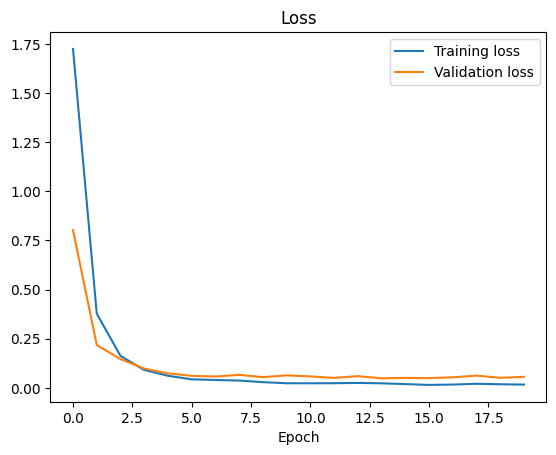

In [20]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [21]:
model.eval()
with torch.no_grad():
    true_labels = []
    pred_labels = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/{experiment_name}_test_data_pred_results.csv")

### Experimental Results

#### Overall Results

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    pred_labels, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9867
Precision: 0.9668
Recall: 0.9513
F1 Score: 0.9571


#### Class-wise Results

In [23]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results/{experiment_name}_precision_recall_fscore_rseed{rseed}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,A1010,0.970588,0.985075,0.977778
1,A1020,1.000000,0.983607,0.991736
2,A1030,0.972603,1.000000,0.986111
3,A2010,0.986667,1.000000,0.993289
4,A2020,1.000000,0.846154,0.916667
5,B1010,0.998014,0.998014,0.998014
6,B1020,0.969466,0.969466,0.969466
7,B2010,0.996396,1.000000,0.998195
8,B2020,1.000000,1.000000,1.000000
9,B2030,1.000000,0.933333,0.965517


In [24]:
# Scarce labels (less than 10)
performance_df['Total Sample Size'] = label_cnt[performance_df['Class']].values
performance_df[performance_df['Total Sample Size'] < 10]  # only when F1 Score can be calculated

,Class,Precision,Recall,F1 Score,Total Sample Size
11,B3020,1.0,1.0,1.0,6
26,D2040,0.0,0.0,0.0,2
27,D2090,1.0,1.0,1.0,5
45,E1030,1.0,1.0,1.0,3


In [25]:
print('Elapsed time: ', (time.time() - start_time)/60, ' minutes')

Elapsed time:  47.43694505294164  minutes
